# NHPCO Conference 2018<br>
# Survival Analysis, Cox Regressions, Multinomial Log Regression
<br>
<br>
## Summary<br>
<br>
**Objective: Identify and define risk factors for Live Discharge from Hospice**<br>
<br>

This document describes and evaluates a dataset comprised of Hospice admissions between the dates of *January 1, 2016 (start of service)* and *December 31, 2017 (Discharge date)*, comprising two years. All individual admissions were for hospice care only. <br>
<br>
Along with general descriptive statistics, this analysis aims to answer some general questions in the identified population:
1. What types of clinical and personal factors influence survival time in the population?
2. What types of factors influence Revocation events, Live Discharge events, or Death individually?
3. Is open-source Social Determinants of Health (SDOH) data informative of revocation/live discharge events?
<br>
<br>




In [7]:
#load R libraries
library(sqldf) #used for joining and reformatting data
library(survival) #used for survival analysis and cox regressions
#library(rms) #used for survival plotting functions
library(plyr) #some data cleaning 


Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite


## Data Description
<br>The dataset is comprised of all hospice admissions occuring after 1/1/2016 with a following discharge event occuring on or before 12/31/17. Admission events were excluded from the analysis if they occurred outside this date range or were seen for other non-Hospice related care.<br>
<br>
#### Variables included for each admission include:
- StartofCare: Date of start of hospice admission
- DischargeDate: Date of Discharge from Hospice service
- Gender: documented gender of person (1 = male, 2 = female)
- ZIPCode: ZIPCode of person, used for attaching Open-source SDOH data
- DateOfBirth: Person's date of birth
- DischargeType: How the person was discharged from care (e.g. Live, death, revocation)
- DischargeStatus: Where the person discharged to or passed away at (e.g. Discharge to home, expired at SNF)
- DischargeReason: Rationale for discharge (only for Live DischargeType)
- ClinicType: Type of clinic and services delivered (Should be only 'Hospice')
- AdvanceDirective: Does person have documented FullCode/DNR?
- TerminalDiagnosis: ICD10 Diagnosis Code for Hospice care 
- DiagnosisDesc: Description of diagnostic code (e.g. 'Alzheimer's disease, unspecified)
- ReferralType: Where the person is being referred from (e.g. Transfer from hospital)
- LevelofCare: Describes level of direct care delivered during Admission 
<br>**(TODO: Join this back into PatientTask, as this can likely change over the course of care. At the very least, verify Admission event is represented by LevelofCare, and not PatientTask/Episode)**
- Race: Person's documented and self-reported race
- InsuranceType: Type of insurance the person has (e.g. Medicare Traditional, None, Medicaid)


In [8]:
#load data
setwd('C:/Users/Mark.Burghart/Documents/projects/hospice_carepoint/data/raw/')
raw <- read.csv('NHPCO_raw.csv', fileEncoding="UTF-8-BOM") # to remove the UTF BOM at start of first column name
head(raw)

AdmissionKey,PatientKey,ZIPCode,StartOfCare,DischargeDate,gender,DateofBirth,DischargeType,DischargeStatus,DischargeReason,ClinicType,AdvanceDirective,TerminalDiagnosis,DiagnosisDesc,ReferralType,LevelofCare,Race,InsuranceType
4852152,1553368,75116,2016-10-28 00:00:00.000,2017-04-12 00:00:00.000,2,1927-01-01 00:00:00.000,Revocation,Discharge to Home or Self Care,NULL,Hospice,No,G309,"Alzheimer's disease, unspecified",Non-health care facility,Routine,Black or African American,Medicare Traditional
5514326,1553368,75116,2017-04-18 00:00:00.000,2017-05-13 00:00:00.000,2,1927-01-01 00:00:00.000,Death,Expired at Long-Term Care Facility,NULL,Hospice,No,G309,"Alzheimer's disease, unspecified",Clinic or physician's office,Routine,Black or African American,Medicare Traditional
3839753,1554021,92399,2016-01-16 00:00:00.000,2016-02-29 00:00:00.000,2,1952-10-17 00:00:00.000,Death,Expired at home,NULL,Hospice,Yes - Full Code / Advanced Cardiac Life Support (ACLS),F0151,Vascular dementia with behavioral disturbance,Clinic or physician's office,Routine,White,Medicare Traditional
6347577,1605855,78852,2017-11-09 00:00:00.000,2017-11-17 00:00:00.000,2,1934-05-08 00:00:00.000,Live,Discharge to Home or Self Care,Patient no longer terminally ill,Hospice,Yes - Do Not Resuscitate (DNR),I69398,Other sequelae of cerebral infarction,Clinic or physician's office,Routine,Hispanic or Latino,Medicare Traditional
5245536,1608127,78852,2017-02-09 00:00:00.000,2017-08-02 00:00:00.000,2,1928-09-05 00:00:00.000,Live,Discharge to Home or Self Care,Patient no longer terminally ill,Hospice,Yes - Do Not Resuscitate (DNR),G301,Alzheimer's disease with late onset,Clinic or physician's office,Routine,NULL,Medicare Traditional
5817025,1608150,78827,2017-06-30 00:00:00.000,2017-11-07 00:00:00.000,1,1937-07-02 00:00:00.000,Live,Discharge to Home or Self Care,Patient no longer terminally ill,Hospice,No,C3490,Malignant neoplasm of unspecified part of unspecified bronchus or lung,Clinic or physician's office,Routine,Hispanic or Latino,Medicare Traditional


In [20]:
dx_counts <- sqldf("select TerminalDiagnosis
                ,DiagnosisDesc
                  ,count(AdmissionKey) as dx_count
                  from raw
                group by TerminalDiagnosis
                  order by count(AdmissionKey) DESC")
head(dx_counts, 20)

TerminalDiagnosis,DiagnosisDesc,dx_count
G309,"Alzheimer's disease, unspecified",5965
J449,"Chronic obstructive pulmonary disease, unspecified",3017
I509,"Heart failure, unspecified",2481
C3490,Malignant neoplasm of unspecified part of unspecified bronchus or lung,1906
G301,Alzheimer's disease with late onset,1731
I2510,Atherosclerotic heart disease of native coronary artery without angina pectoris,1433
G20,Parkinson's disease,1418
G311,"Senile degeneration of brain, not elsewhere classified",1348
J441,Chronic obstructive pulmonary disease with (acute) exacerbation,1311
C61,Malignant neoplasm of prostate,1065


<br>
## Feature Engineering and Cleaning
<br>
Some variables will need to be manually calculated from the raw dataset. For instance 'Age' isn't included in the manual extract, but could (and will) be easily added. Additionally, Diagnosis codes need to be collapsed into categories, as there are ~ 1,900 different codes/diagnoses. Collapsing/binning these into categories will help analysis intrepretation. <br>
<br>
Lastly, open-source SDOH data will be added and joined to the patient-admission dataset. The Social Vulnerability Index released by the CDC will be used to represent the general vulnerability a person experiences. The SVI is available for census tracts, but because of the limited geocoded latitude and longitude data, county-level data will be used instead.

In [3]:
str(raw)

'data.frame':	57941 obs. of  18 variables:
 $ AdmissionKey     : int  4852152 5514326 3839753 6347577 5245536 5817025 4534544 5239162 5749676 5749676 ...
 $ PatientKey       : int  1553368 1553368 1554021 1605855 1608127 1608150 1672719 1680798 1681828 1681828 ...
 $ ZIPCode          : int  75116 75116 92399 78852 78852 78827 92630 77504 77539 77539 ...
 $ StartOfCare      : Factor w/ 732 levels "2016-01-01 00:00:00.000",..: 302 474 16 679 406 547 214 406 532 532 ...
 $ DischargeDate    : Factor w/ 733 levels "2015-07-15 00:00:00.000",..: 470 501 62 689 582 679 220 541 542 542 ...
 $ gender           : int  2 2 2 2 2 1 2 1 2 2 ...
 $ DateofBirth      : Factor w/ 16829 levels "1826-07-25 00:00:00.000",..: 3894 3894 12867 6565 4505 7708 1446 6876 13773 13773 ...
 $ DischargeType    : Factor w/ 3 levels "Death","Live",..: 3 1 1 2 2 2 1 1 1 1 ...
 $ DischargeStatus  : Factor w/ 15 levels "Discharge to Home or Self Care",..: 1 12 7 1 1 1 7 12 6 6 ...
 $ DischargeReason  : Factor w/ 5 levels

In [4]:
#convert factors to dates
dates <- c('StartOfCare', 'DischargeDate', 'DateofBirth')
raw[,dates] <- lapply(raw[,dates],as.Date) 

#convert TerminalDiagnosis to string for future truncating
raw$TerminalDiagnosis <- as.character(raw$TerminalDiagnosis)

#convert zipcode, gender, admissionkey,Patientkey to factor
fact <- c('AdmissionKey', 'PatientKey', 'ZIPCode', 'gender')
raw[,fact] <- lapply(raw[,fact],as.factor)

In [5]:
str(raw)

'data.frame':	57941 obs. of  18 variables:
 $ AdmissionKey     : Factor w/ 57003 levels "2700068","2756128",..: 23045 37838 1017 54319 31986 44154 16070 31850 42733 42733 ...
 $ PatientKey       : Factor w/ 53749 levels "1553368","1554021",..: 1 1 2 3 4 5 6 7 8 8 ...
 $ ZIPCode          : Factor w/ 5492 levels "612","623","627",..: 2831 2831 4892 3760 3760 3753 4946 3388 3406 3406 ...
 $ StartOfCare      : Date, format: "2016-10-28" "2017-04-18" ...
 $ DischargeDate    : Date, format: "2017-04-12" "2017-05-13" ...
 $ gender           : Factor w/ 2 levels "1","2": 2 2 2 2 2 1 2 1 2 2 ...
 $ DateofBirth      : Date, format: "1927-01-01" "1927-01-01" ...
 $ DischargeType    : Factor w/ 3 levels "Death","Live",..: 3 1 1 2 2 2 1 1 1 1 ...
 $ DischargeStatus  : Factor w/ 15 levels "Discharge to Home or Self Care",..: 1 12 7 1 1 1 7 12 6 6 ...
 $ DischargeReason  : Factor w/ 5 levels "Discharge for cause (i.e. patient/staff safety)",..: 2 2 2 4 4 4 2 2 2 2 ...
 $ ClinicType       : Factor w/ 

In [6]:
#Diagnosis engineering
raw$DiagnosisGroup <- substr(raw$TerminalDiagnosis, 1,3)
head(raw)

AdmissionKey,PatientKey,ZIPCode,StartOfCare,DischargeDate,gender,DateofBirth,DischargeType,DischargeStatus,DischargeReason,ClinicType,AdvanceDirective,TerminalDiagnosis,DiagnosisDesc,ReferralType,LevelofCare,Race,InsuranceType,DiagnosisGroup
4852152,1553368,75116,2016-10-28,2017-04-12,2,1927-01-01,Revocation,Discharge to Home or Self Care,NULL,Hospice,No,G309,"Alzheimer's disease, unspecified",Non-health care facility,Routine,Black or African American,Medicare Traditional,G30
5514326,1553368,75116,2017-04-18,2017-05-13,2,1927-01-01,Death,Expired at Long-Term Care Facility,NULL,Hospice,No,G309,"Alzheimer's disease, unspecified",Clinic or physician's office,Routine,Black or African American,Medicare Traditional,G30
3839753,1554021,92399,2016-01-16,2016-02-29,2,1952-10-17,Death,Expired at home,NULL,Hospice,Yes - Full Code / Advanced Cardiac Life Support (ACLS),F0151,Vascular dementia with behavioral disturbance,Clinic or physician's office,Routine,White,Medicare Traditional,F01
6347577,1605855,78852,2017-11-09,2017-11-17,2,1934-05-08,Live,Discharge to Home or Self Care,Patient no longer terminally ill,Hospice,Yes - Do Not Resuscitate (DNR),I69398,Other sequelae of cerebral infarction,Clinic or physician's office,Routine,Hispanic or Latino,Medicare Traditional,I69
5245536,1608127,78852,2017-02-09,2017-08-02,2,1928-09-05,Live,Discharge to Home or Self Care,Patient no longer terminally ill,Hospice,Yes - Do Not Resuscitate (DNR),G301,Alzheimer's disease with late onset,Clinic or physician's office,Routine,NULL,Medicare Traditional,G30
5817025,1608150,78827,2017-06-30,2017-11-07,1,1937-07-02,Live,Discharge to Home or Self Care,Patient no longer terminally ill,Hospice,No,C3490,Malignant neoplasm of unspecified part of unspecified bronchus or lung,Clinic or physician's office,Routine,Hispanic or Latino,Medicare Traditional,C34


In [7]:
#load diagnosis datasets to join for group and cluster level information
icd10_cluster <- read.csv('ICD10_clusters.csv', fileEncoding="UTF-8-BOM")
icd10_group <- read.csv('icd10_cm_order_2018.csv', fileEncoding="UTF-8-BOM")

In [8]:
#create diagnosis stratifications for cluster and grouping variables
df <- sqldf(
    "select x.*
        ,y.Classification as ICD10_cluster
        ,z.DiagnosisDesc as ICD10_grouping
    from raw as x
    inner join icd10_cluster as y
    on x.DiagnosisGroup = y.Code
    inner join icd10_group as z
    on x.DiagnosisGroup = z.DiagnosisCode
    ")


In [9]:
head(df, 100)

AdmissionKey,PatientKey,ZIPCode,StartOfCare,DischargeDate,gender,DateofBirth,DischargeType,DischargeStatus,DischargeReason,...,AdvanceDirective,TerminalDiagnosis,DiagnosisDesc,ReferralType,LevelofCare,Race,InsuranceType,DiagnosisGroup,ICD10_cluster,ICD10_grouping
4852152,1553368,75116,2016-10-28,2017-04-12,2,1927-01-01,Revocation,Discharge to Home or Self Care,NULL,...,No,G309,"Alzheimer's disease, unspecified",Non-health care facility,Routine,Black or African American,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease
5514326,1553368,75116,2017-04-18,2017-05-13,2,1927-01-01,Death,Expired at Long-Term Care Facility,NULL,...,No,G309,"Alzheimer's disease, unspecified",Clinic or physician's office,Routine,Black or African American,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease
3839753,1554021,92399,2016-01-16,2016-02-29,2,1952-10-17,Death,Expired at home,NULL,...,Yes - Full Code / Advanced Cardiac Life Support (ACLS),F0151,Vascular dementia with behavioral disturbance,Clinic or physician's office,Routine,White,Medicare Traditional,F01,Mental and behavioural disorders,Vascular dementia
6347577,1605855,78852,2017-11-09,2017-11-17,2,1934-05-08,Live,Discharge to Home or Self Care,Patient no longer terminally ill,...,Yes - Do Not Resuscitate (DNR),I69398,Other sequelae of cerebral infarction,Clinic or physician's office,Routine,Hispanic or Latino,Medicare Traditional,I69,Diseases of the circulatory system,Sequelae of cerebrovascular disease
5245536,1608127,78852,2017-02-09,2017-08-02,2,1928-09-05,Live,Discharge to Home or Self Care,Patient no longer terminally ill,...,Yes - Do Not Resuscitate (DNR),G301,Alzheimer's disease with late onset,Clinic or physician's office,Routine,NULL,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease
5817025,1608150,78827,2017-06-30,2017-11-07,1,1937-07-02,Live,Discharge to Home or Self Care,Patient no longer terminally ill,...,No,C3490,Malignant neoplasm of unspecified part of unspecified bronchus or lung,Clinic or physician's office,Routine,Hispanic or Latino,Medicare Traditional,C34,Neoplasms,Malignant neoplasm of bronchus and lung
4534544,1672719,92630,2016-08-01,2016-08-05,2,1920-02-23,Death,Expired at home,NULL,...,No,G309,"Alzheimer's disease, unspecified",Transfer from hospital,Routine,Hispanic or Latino,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease
5239162,1680798,77504,2017-02-09,2017-06-22,1,1935-03-15,Death,Expired at Long-Term Care Facility,NULL,...,Yes - Do Not Resuscitate (DNR),I5020,Unspecified systolic (congestive) heart failure,Non-health care facility,Routine,White,Medicare Traditional,I50,Diseases of the circulatory system,Heart failure
5749676,1681828,77539,2017-06-15,2017-06-23,2,1956-02-03,Death,Expired at Assisted Living,NULL,...,Yes - Do Not Resuscitate (DNR),G309,"Alzheimer's disease, unspecified",Non-health care facility,Routine,NULL,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease
5749676,1681828,77539,2017-06-15,2017-06-23,2,1956-02-03,Death,Expired at Assisted Living,NULL,...,Yes - Do Not Resuscitate (DNR),G309,"Alzheimer's disease, unspecified",Non-health care facility,Routine,NULL,None- No Charge for Current Service,G30,Diseases of the nervous system,Alzheimer's disease


### TODO: ADD IN SVI FILES AND DATA TO DF

In [10]:
#create 'time' object, representing time to discharge/death/revocation
df$time <- as.numeric(df$DischargeDate - df$StartOfCare)

#create mortality indicator
df$mortality <- as.factor(ifelse(df$DischargeType == 'Death', 1, 0)) # 1 = Death, 0 = Live/Revocation

#revocation indicator
df$revocation <- as.factor(ifelse(df$DischargeType == 'Revocation', 1, 0)) # 1 = Revocation, 0 = Death/Live DC 

#Live Discharge due to improved prognosis (Patient no longer terminally ill)
df$live_discharge <- as.factor(ifelse(df$DischargeType == 'Live' & df$DischargeReason == 'Patient no longer terminally ill', 1,
                                  ifelse(df$DischargeType == 'Live' & df$DischargeReason != 'Patient no longer terminally ill', 2, 0))) #1 = DC bc improved prognosis, 2 = live discharge, 0 = NA, non-live dc
#age
today <- as.Date('2018-03-30')
df$age <- as.integer((today - df$DateofBirth) / 365.25)

#Hospice Discharge Reason
df$DCReason <- as.factor(ifelse(df$mortality == 1, 'Death',
                               ifelse(df$revocation == 1, 'Revocation',
                                     ifelse(df$live_discharge == 1, 'Improved Prognosis',
                                           ifelse(df$live_discharge == 2,'Live DC', 'Unknown'))))) #1 = death, 2 = revocation, 3 = dc due to improved prognosis, 4 = LiveDC (other), 0 = unknown

In [11]:
head(df, 100)

AdmissionKey,PatientKey,ZIPCode,StartOfCare,DischargeDate,gender,DateofBirth,DischargeType,DischargeStatus,DischargeReason,...,InsuranceType,DiagnosisGroup,ICD10_cluster,ICD10_grouping,time,mortality,revocation,live_discharge,age,DCReason
4852152,1553368,75116,2016-10-28,2017-04-12,2,1927-01-01,Revocation,Discharge to Home or Self Care,NULL,...,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease,166,0,1,0,91,Revocation
5514326,1553368,75116,2017-04-18,2017-05-13,2,1927-01-01,Death,Expired at Long-Term Care Facility,NULL,...,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease,25,1,0,0,91,Death
3839753,1554021,92399,2016-01-16,2016-02-29,2,1952-10-17,Death,Expired at home,NULL,...,Medicare Traditional,F01,Mental and behavioural disorders,Vascular dementia,44,1,0,0,65,Death
6347577,1605855,78852,2017-11-09,2017-11-17,2,1934-05-08,Live,Discharge to Home or Self Care,Patient no longer terminally ill,...,Medicare Traditional,I69,Diseases of the circulatory system,Sequelae of cerebrovascular disease,8,0,0,1,83,Improved Prognosis
5245536,1608127,78852,2017-02-09,2017-08-02,2,1928-09-05,Live,Discharge to Home or Self Care,Patient no longer terminally ill,...,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease,174,0,0,1,89,Improved Prognosis
5817025,1608150,78827,2017-06-30,2017-11-07,1,1937-07-02,Live,Discharge to Home or Self Care,Patient no longer terminally ill,...,Medicare Traditional,C34,Neoplasms,Malignant neoplasm of bronchus and lung,130,0,0,1,80,Improved Prognosis
4534544,1672719,92630,2016-08-01,2016-08-05,2,1920-02-23,Death,Expired at home,NULL,...,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease,4,1,0,0,98,Death
5239162,1680798,77504,2017-02-09,2017-06-22,1,1935-03-15,Death,Expired at Long-Term Care Facility,NULL,...,Medicare Traditional,I50,Diseases of the circulatory system,Heart failure,133,1,0,0,83,Death
5749676,1681828,77539,2017-06-15,2017-06-23,2,1956-02-03,Death,Expired at Assisted Living,NULL,...,Medicare Traditional,G30,Diseases of the nervous system,Alzheimer's disease,8,1,0,0,62,Death
5749676,1681828,77539,2017-06-15,2017-06-23,2,1956-02-03,Death,Expired at Assisted Living,NULL,...,None- No Charge for Current Service,G30,Diseases of the nervous system,Alzheimer's disease,8,1,0,0,62,Death


In [12]:
#convert DiagnosisGroup, ICD10_cluster, and ICD10_grouping to factor
fact <- c('DiagnosisGroup', 'ICD10_cluster', 'ICD10_grouping')
df[,fact] <- lapply(df[,fact],as.factor)

In [13]:
str(df)

'data.frame':	57768 obs. of  27 variables:
 $ AdmissionKey     : Factor w/ 57003 levels "2700068","2756128",..: 23045 37838 1017 54319 31986 44154 16070 31850 42733 42733 ...
 $ PatientKey       : Factor w/ 53749 levels "1553368","1554021",..: 1 1 2 3 4 5 6 7 8 8 ...
 $ ZIPCode          : Factor w/ 5492 levels "612","623","627",..: 2831 2831 4892 3760 3760 3753 4946 3388 3406 3406 ...
 $ StartOfCare      : Date, format: "2016-10-28" "2017-04-18" ...
 $ DischargeDate    : Date, format: "2017-04-12" "2017-05-13" ...
 $ gender           : Factor w/ 2 levels "1","2": 2 2 2 2 2 1 2 1 2 2 ...
 $ DateofBirth      : Date, format: "1927-01-01" "1927-01-01" ...
 $ DischargeType    : Factor w/ 3 levels "Death","Live",..: 3 1 1 2 2 2 1 1 1 1 ...
 $ DischargeStatus  : Factor w/ 15 levels "Discharge to Home or Self Care",..: 1 12 7 1 1 1 7 12 6 6 ...
 $ DischargeReason  : Factor w/ 5 levels "Discharge for cause (i.e. patient/staff safety)",..: 2 2 2 4 4 4 2 2 2 2 ...
 $ ClinicType       : Factor w/ 

#### Numeric encodings
<br>
For most models, character-based (strings) factors need to be converted to dymmy variables with numeric encodings representing each classification. 

In [14]:
#AdvanceDirective
df$AdvanceDirective.n <- as.integer(df$AdvanceDirective)
#ReferralType
df$ReferralType.n <- as.integer(df$ReferralType)
#LevelofCare
df$LevelofCare.n <- as.integer(df$LevelofCare)
#Race
df$Race.n <- as.integer(df$Race)
#InsuranceType
df$InsuranceType.n <- as.integer(df$InsuranceType)
#ICD10_cluster
df$ICD10_cluster.n <- as.integer(df$ICD10_cluster)
#ICD10_grouping
df$ICD10_grouping.n <- as.integer(df$ICD10_grouping)
#TerminalDiagnosis
df$TerminalDiagnosis.n <- as.integer(as.factor(df$TerminalDiagnosis))
#DCReason
df$DCReason.n <- as.integer(df$DCReason)

In [15]:
head(df)

AdmissionKey,PatientKey,ZIPCode,StartOfCare,DischargeDate,gender,DateofBirth,DischargeType,DischargeStatus,DischargeReason,...,DCReason,AdvanceDirective.n,ReferralType.n,LevelofCare.n,Race.n,InsuranceType.n,ICD10_cluster.n,ICD10_grouping.n,TerminalDiagnosis.n,DCReason.n
4852152,1553368,75116,2016-10-28,2017-04-12,2,1927-01-01,Revocation,Discharge to Home or Self Care,NULL,...,Revocation,1,4,5,3,6,10,28,848,4
5514326,1553368,75116,2017-04-18,2017-05-13,2,1927-01-01,Death,Expired at Long-Term Care Facility,NULL,...,Death,1,1,5,3,6,10,28,848,1
3839753,1554021,92399,2016-01-16,2016-02-29,2,1952-10-17,Death,Expired at home,NULL,...,Death,5,1,5,7,6,17,512,791,1
6347577,1605855,78852,2017-11-09,2017-11-17,2,1934-05-08,Live,Discharge to Home or Self Care,Patient no longer terminally ill,...,Improved Prognosis,4,1,5,4,6,5,468,1246,2
5245536,1608127,78852,2017-02-09,2017-08-02,2,1928-09-05,Live,Discharge to Home or Self Care,Patient no longer terminally ill,...,Improved Prognosis,4,1,5,6,6,10,28,846,2
5817025,1608150,78827,2017-06-30,2017-11-07,1,1937-07-02,Live,Discharge to Home or Self Care,Patient no longer terminally ill,...,Improved Prognosis,1,1,5,4,6,18,212,171,2


In [16]:
#write out csv for external keeping
#write.csv(df, 'NHPCO_cleaned.csv')
str(df)

'data.frame':	57768 obs. of  36 variables:
 $ AdmissionKey       : Factor w/ 57003 levels "2700068","2756128",..: 23045 37838 1017 54319 31986 44154 16070 31850 42733 42733 ...
 $ PatientKey         : Factor w/ 53749 levels "1553368","1554021",..: 1 1 2 3 4 5 6 7 8 8 ...
 $ ZIPCode            : Factor w/ 5492 levels "612","623","627",..: 2831 2831 4892 3760 3760 3753 4946 3388 3406 3406 ...
 $ StartOfCare        : Date, format: "2016-10-28" "2017-04-18" ...
 $ DischargeDate      : Date, format: "2017-04-12" "2017-05-13" ...
 $ gender             : Factor w/ 2 levels "1","2": 2 2 2 2 2 1 2 1 2 2 ...
 $ DateofBirth        : Date, format: "1927-01-01" "1927-01-01" ...
 $ DischargeType      : Factor w/ 3 levels "Death","Live",..: 3 1 1 2 2 2 1 1 1 1 ...
 $ DischargeStatus    : Factor w/ 15 levels "Discharge to Home or Self Care",..: 1 12 7 1 1 1 7 12 6 6 ...
 $ DischargeReason    : Factor w/ 5 levels "Discharge for cause (i.e. patient/staff safety)",..: 2 2 2 4 4 4 2 2 2 2 ...
 $ ClinicTyp

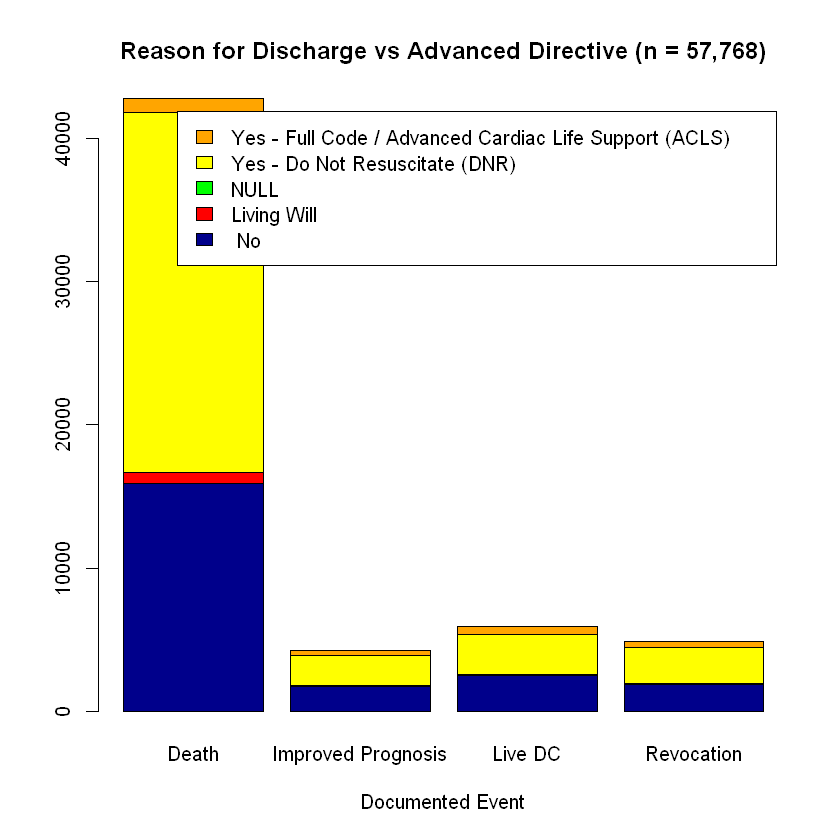

In [17]:
#sample distribution of DCReason when factoring in Advanced Directive
counts <- table(df$AdvanceDirective, df$DCReason)
barplot(counts, main = "Reason for Discharge vs Advanced Directive (n = 57,768)",
       xlab = "Documented Event",
       col = c("darkblue", "red", "green", "yellow", "orange"),
       legend = rownames(counts), beside=FALSE)

# Survival Analysis: Death Group
<br>
3 survival analyses will be completed for 3 distinct events in the dataset: Death, Revocation, and Live Discharge NOT RELATED to improved prognosis.

In [18]:
#drop unnecessary columns from df
df_surv <- subset(df, select=c(gender,age,time,mortality,revocation,live_discharge,AdvanceDirective.n, ReferralType.n,LevelofCare.n, Race.n,
                         InsuranceType.n, ICD10_cluster.n, ICD10_grouping.n, TerminalDiagnosis.n))
#subset groups
death <- subset(df_surv, df$mortality == 1)
revocation <- subset(df_surv, df$revocation == 1)
livedc <- subset(df_surv, df$live_discharge == 2)

#create survival objects
death$surv_obj <- with(death, Surv(time, mortality == 1)) #survival object for true mortality event
revocation$surv_obj <- with(revocation, Surv(time, revocation == 1)) #survival object for true revocation event
livedc$surv_obj <- with(livedc, Surv(time, live_discharge == 2)) #in this instance Live DC is defined as live DC event not related to improved prognosis.

head(death)

,gender,age,time,mortality,revocation,live_discharge,AdvanceDirective.n,ReferralType.n,LevelofCare.n,Race.n,InsuranceType.n,ICD10_cluster.n,ICD10_grouping.n,TerminalDiagnosis.n,surv_obj
2,2,91,25,1,0,0,1,1,5,3,6,10,28,848,25
3,2,65,44,1,0,0,5,1,5,7,6,17,512,791,44
7,2,98,4,1,0,0,1,8,5,4,6,10,28,848,4
8,1,83,133,1,0,0,4,4,5,7,6,5,154,1059,133
9,2,62,8,1,0,0,4,4,5,6,6,10,28,848,8
10,2,62,8,1,0,0,4,4,5,6,7,10,28,848,8


In [19]:
########## Death cohort ##############
#Kaplan Meier estimator without grouping
km.as.one <- survfit(formula = surv_obj ~ 1, data = death, conf.type = "log-log")
km.as.one

km.by.gender <- survfit(formula = surv_obj ~ gender, data = death, conf.type = "log-log")
km.by.gender

km.by.ICD10_cluster.n<- survfit(formula = surv_obj ~ ICD10_cluster.n, data = death, conf.type = "log-log")
km.by.ICD10_cluster.n

Call: survfit(formula = surv_obj ~ 1, data = death, conf.type = "log-log")

      n  events  median 0.95LCL 0.95UCL 
  42765   42765      15      15      15 

Call: survfit(formula = surv_obj ~ gender, data = death, conf.type = "log-log")

             n events median 0.95LCL 0.95UCL
gender=1 19239  19239     13      12      13
gender=2 23526  23526     17      16      17

Call: survfit(formula = surv_obj ~ ICD10_cluster.n, data = death, conf.type = "log-log")

                       n events median 0.95LCL 0.95UCL
ICD10_cluster.n=1      6      6    5.5       0      NA
ICD10_cluster.n=2    370    370    4.0       4       5
ICD10_cluster.n=3     27     27    9.0       5      26
ICD10_cluster.n=4    110    110   16.5      10      25
ICD10_cluster.n=5  10894  10894   14.0      13      15
ICD10_cluster.n=6   1085   1085    9.0       8      10
ICD10_cluster.n=7      2      2    8.5       2      NA
ICD10_cluster.n=8   1522   1522    7.0       7       8
ICD10_cluster.n=9    117    117   15.0      10      19
ICD10_cluster.n=10  8916   8916   24.0      22      25
ICD10_cluster.n=11  4183   4183   11.0      10      12
ICD10_cluster.n=12    15     15   57.0       7      69
ICD10_cluster.n=13   754    754   16.0      14      20
ICD10_cluster.n=14     1      1    1.0      NA      NA
ICD10_cluster.n=15    22     22    7.5       3      12
ICD10_cluster.n=16   156    15

In the entire death population, 42,765 'events' were observed, represented by admissions that ultimately culminated with the individual passing away during hospice care. The median length of care was 15 days. Additionally, specifically factoring in gender on survival, Males have shorter survival durations during hospice care when compared to females, 13 vs 17 median days, respectively. 

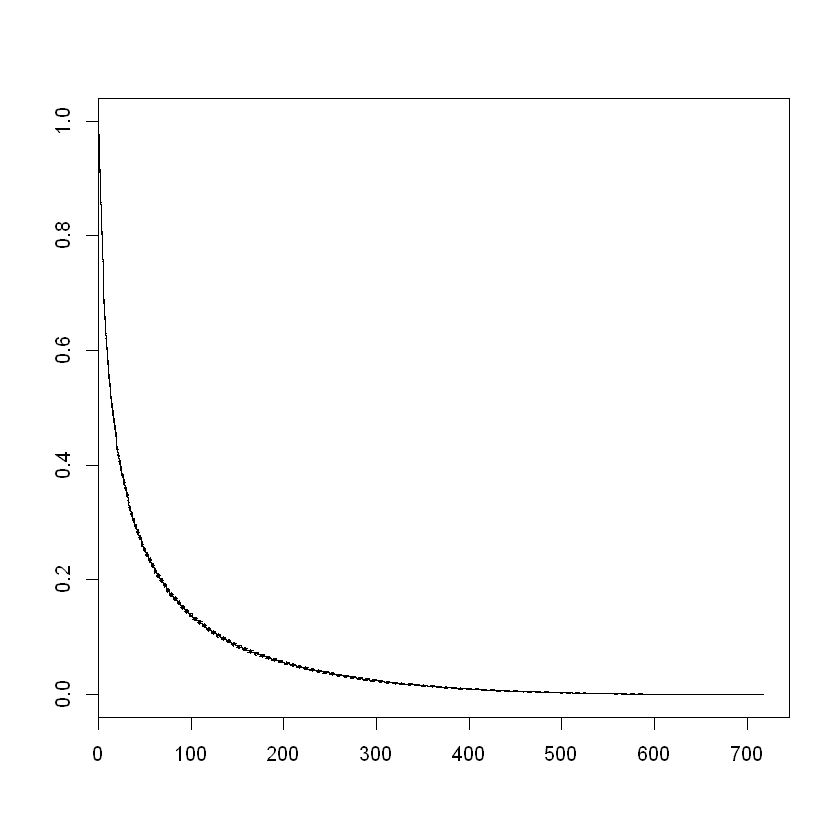

In [20]:
plot(km.as.one)

Above plot represents the collective survival probability at any given instance in time (days). For instance, in the sample of people who ended up passing away, there was a 20% likelihood that they would still be alive at day 100. There appear to be some obvious outliers that need to be removed, as an instance of 700 days was observed, which shouldn't be represented in a sample of hospice patients.

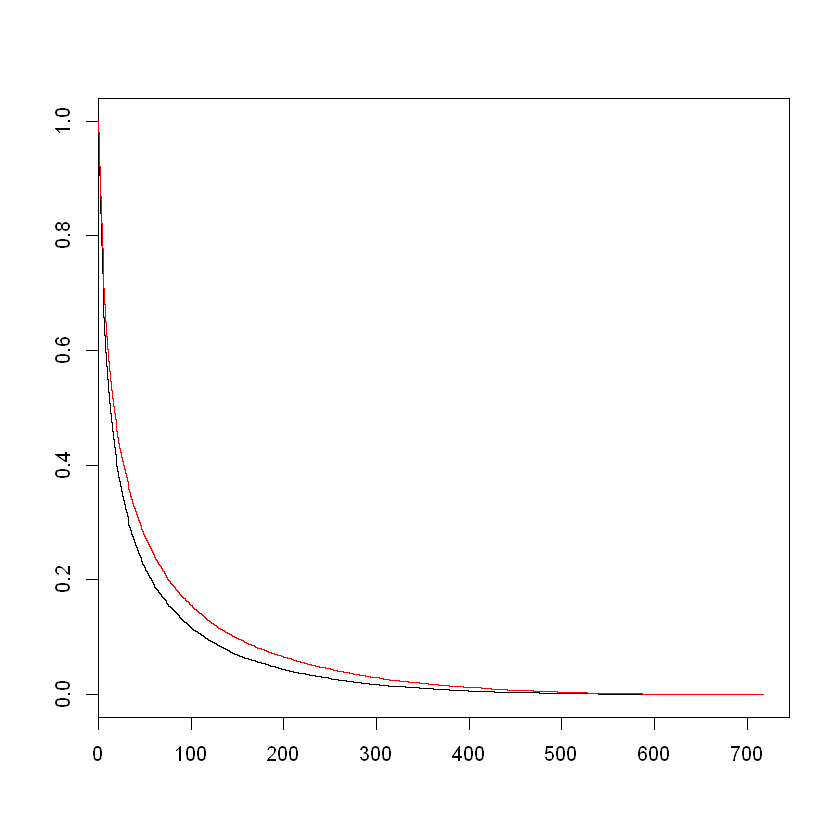

In [21]:
plot(km.by.gender, col = c(1,2))

Graphically, this again shows the longer period of survival and slightly higher probability of survival of women (shown in red) when compared to men.

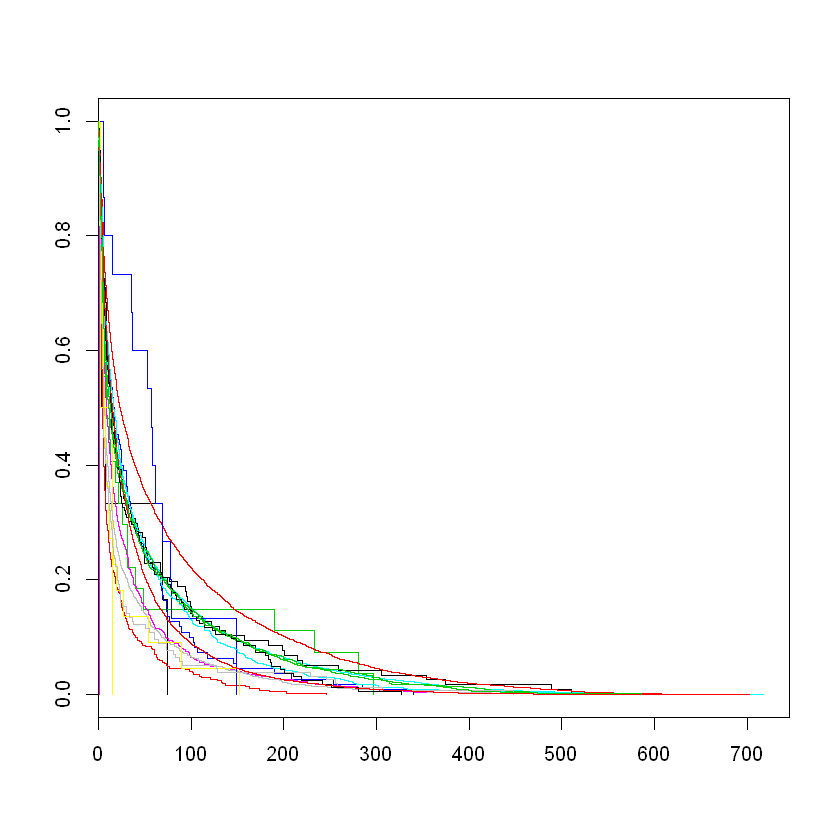

In [22]:
plot(km.by.ICD10_cluster.n, col = c(1:19))

While not the most informative plot, this clearly shows different diagnosis clusters have an influence on the survival probability at any given time, even when enrolled in hospice care. 

In [23]:
#Additional comparisons: AdvanceDirective, ReferralType, LevelofCare
km.by.AdvanceDirective.n<- survfit(formula = surv_obj ~ AdvanceDirective.n, data = death, conf.type = "log-log")
km.by.AdvanceDirective.n

km.by.ReferralType.n<- survfit(formula = surv_obj ~ ReferralType.n, data = death, conf.type = "log-log")
km.by.ReferralType.n

km.by.LevelofCare.n<- survfit(formula = surv_obj ~ LevelofCare.n, data = death, conf.type = "log-log")
km.by.LevelofCare.n

Call: survfit(formula = surv_obj ~ AdvanceDirective.n, data = death, 
    conf.type = "log-log")

                         n events median 0.95LCL 0.95UCL
AdvanceDirective.n=1 15885  15885   13.0      12      13
AdvanceDirective.n=2   762    762   19.0      16      23
AdvanceDirective.n=3     4      4   16.5       1      NA
AdvanceDirective.n=4 25148  25148   16.0      16      17
AdvanceDirective.n=5   966    966   18.0      16      20

Call: survfit(formula = surv_obj ~ ReferralType.n, data = death, conf.type = "log-log")

                     n events median 0.95LCL 0.95UCL
ReferralType.n=1 12013  12013     21      20      22
ReferralType.n=2     3      3     35       7      NA
ReferralType.n=3   906    906     23      19      27
ReferralType.n=4 13472  13472     17      16      18
ReferralType.n=5     1      1      0      NA      NA
ReferralType.n=6  2234   2234     22      20      24
ReferralType.n=7   706    706     41      34      50
ReferralType.n=8 10667  10667      8       8       8
ReferralType.n=9  2763   2763     13      12      14

Call: survfit(formula = surv_obj ~ LevelofCare.n, data = death, conf.type = "log-log")

                    n events median 0.95LCL 0.95UCL
LevelofCare.n=1  1607   1607   17.0      15      19
LevelofCare.n=2  2710   2710    3.0       3       3
LevelofCare.n=3    12     12    7.5       0      51
LevelofCare.n=4   226    226   18.0      16      25
LevelofCare.n=5 38210  38210   17.0      16      17

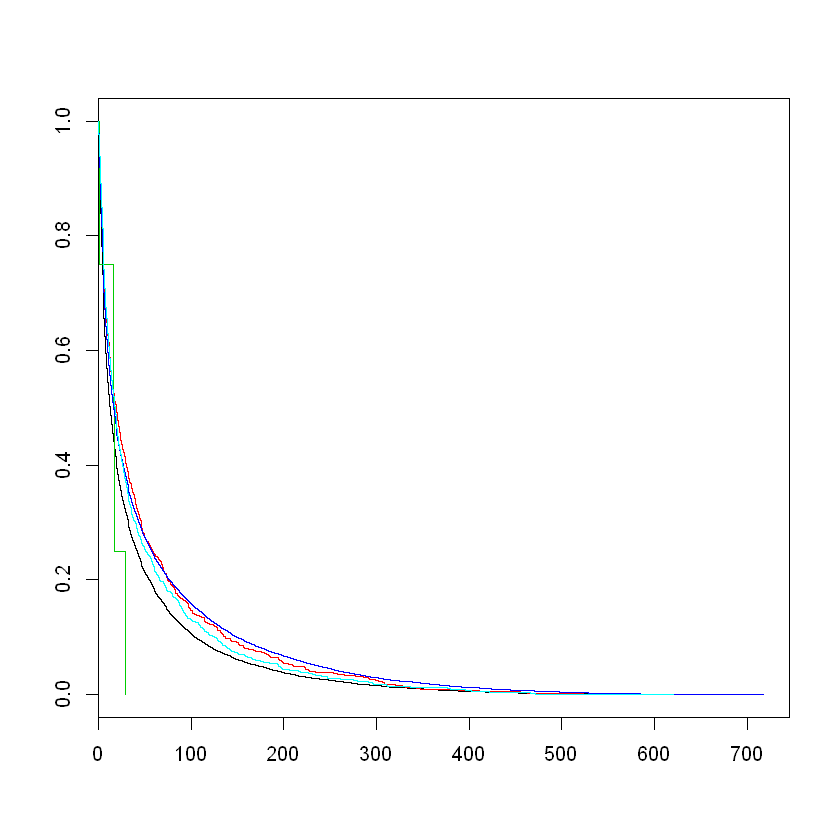

In [24]:
plot(km.by.AdvanceDirective.n, col = c(1:5))

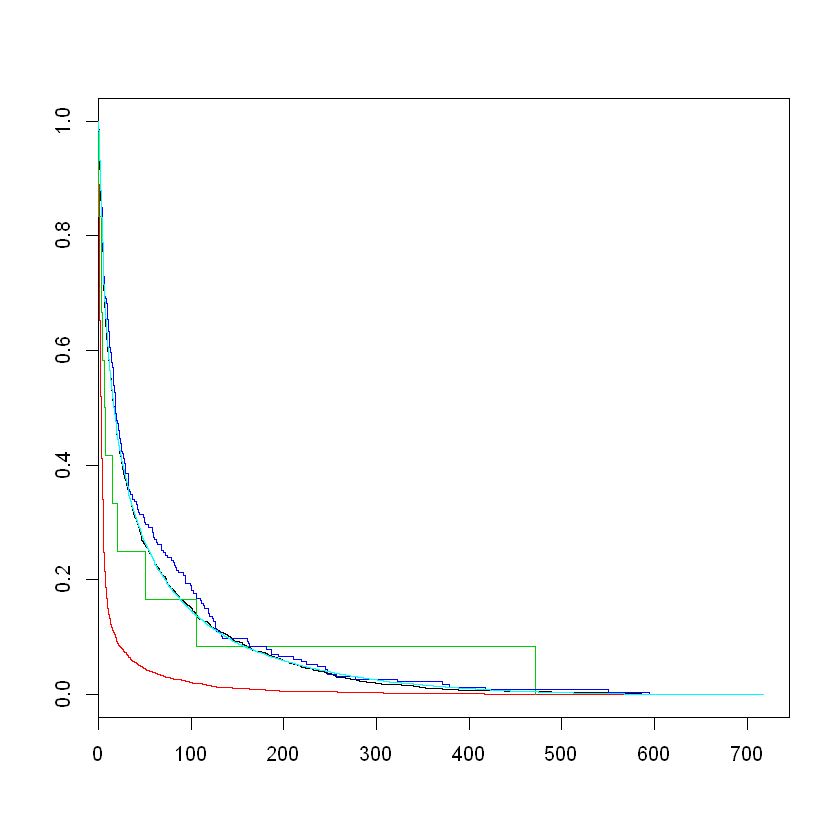

In [25]:
plot(km.by.LevelofCare.n, col = c(1:5))

# Cox Regression (Proportional Hazards regression)
<br>
**Cox Regression** is a method for investigating the effects of several variables upon the time a specified event takes place. In this case, we are interested in 3 particular events: Death, Revocation, or Live Discharge not due to improved prognosis. 

In [26]:
#### DEATH Group ####
#fit cox regression: age, gender, AdvanceDirective.n, ReferralType.n, LevelofCare.n, Race.n, InsuranceType.n, ICD10_cluster.n, ICD10_grouping.n, TerminalDiagnosis.n
res.cox.death <- coxph(surv_obj ~ age + gender + AdvanceDirective.n + ReferralType.n + LevelofCare.n + Race.n + InsuranceType.n + ICD10_cluster.n + ICD10_grouping.n + TerminalDiagnosis.n,
                      data = death)
res.cox.death

Call:
coxph(formula = surv_obj ~ age + gender + AdvanceDirective.n + 
    ReferralType.n + LevelofCare.n + Race.n + InsuranceType.n + 
    ICD10_cluster.n + ICD10_grouping.n + TerminalDiagnosis.n, 
    data = death)

                         coef exp(coef)  se(coef)      z       p
age                 -6.83e-03  9.93e-01  4.21e-04 -16.22 < 2e-16
gender2             -1.18e-01  8.89e-01  9.86e-03 -11.96 < 2e-16
AdvanceDirective.n  -5.72e-02  9.44e-01  3.31e-03 -17.29 < 2e-16
ReferralType.n       5.06e-02  1.05e+00  1.74e-03  29.08 < 2e-16
LevelofCare.n       -1.26e-01  8.82e-01  4.53e-03 -27.73 < 2e-16
Race.n              -6.20e-03  9.94e-01  3.35e-03  -1.85   0.064
InsuranceType.n      8.99e-03  1.01e+00  3.52e-03   2.56   0.011
ICD10_cluster.n      6.86e-03  1.01e+00  1.38e-03   4.98 6.5e-07
ICD10_grouping.n     2.07e-04  1.00e+00  3.67e-05   5.63 1.8e-08
TerminalDiagnosis.n  7.35e-05  1.00e+00  1.53e-05   4.79 1.7e-06

Likelihood ratio test=2579  on 10 df, p=0
n= 42765, number of event

Regression model for the population of individuals dying had many significant variables. All were significant except race, which was close (*p*=0.06)

In [27]:
(res.zph1 <- cox.zph(res.cox.death))

                         rho   chisq        p
age                  0.00644    1.76 1.85e-01
gender2              0.01895   15.40 8.69e-05
AdvanceDirective.n   0.00896    3.45 6.33e-02
ReferralType.n      -0.06797  200.67 0.00e+00
LevelofCare.n        0.12229  579.37 0.00e+00
Race.n              -0.02012   17.11 3.53e-05
InsuranceType.n     -0.00672    1.91 1.67e-01
ICD10_cluster.n      0.02334   26.16 3.15e-07
ICD10_grouping.n    -0.01604   10.98 9.19e-04
TerminalDiagnosis.n -0.05690  159.79 0.00e+00
GLOBAL                    NA 1396.78 0.00e+00

May have violated some PH assumptions, as the p-value with the chisq shouldn't be significant.

# Logistic Regression modeling

Multinomial logistic regression is going to be used to model the nominal outcome 'DCReason', or categorical reason for discharge. Possible outcome classifications could be death, improved prognosis, revocation, or live discharge. These events represent why a person discontinues hospice care. The live discharge category is a bit of a catch all...


In [28]:
#library(foreign)
#library(nnet)
library(ggplot2)
#library(reshape2)


Multinomial regression reports the odds of being in a different outcome category in reference to some base group. Here, I've selected the 'base group' comparison as anyone with the outcome of death.

In [36]:
#set reference group for outcome to be 'Death'
df$outcome <- relevel(df$DCReason, ref = 'Death')
#set predictor variables to factors:
fact <- c('AdvanceDirective', 'ReferralType', 'LevelofCare', 'Race', 'InsuranceType', 'ICD10_cluster', 'ICD10_grouping')
df[,fact] <- lapply(df[,fact],as.factor)

In [38]:
#run model
library(nnet)
model <- multinom(outcome ~ age + gender + AdvanceDirective + ReferralType + 
                  LevelofCare + Race + InsuranceType + ICD10_cluster, data = df)

# weights:  244 (180 variable)
initial  value 80083.452653 
iter  10 value 51600.403039
iter  20 value 50019.425056
iter  30 value 47195.476815
iter  40 value 46586.396256
iter  50 value 46314.506697
iter  60 value 45917.531826
iter  70 value 45776.219297
iter  80 value 45730.463896
iter  90 value 45704.907027
iter 100 value 45697.073073
final  value 45697.073073 
stopped after 100 iterations


In [39]:
summary(model)

Call:
multinom(formula = outcome ~ age + gender + AdvanceDirective + 
    ReferralType + LevelofCare + Race + InsuranceType + ICD10_cluster, 
    data = df)

Coefficients:
                   (Intercept)         age   gender2
Improved Prognosis   -3.660277 -0.02172307 0.2356704
Live DC              -1.568287 -0.02553862 0.1166679
Revocation           -2.984560 -0.02579433 0.1037421
                   AdvanceDirectiveLiving Will AdvanceDirectiveNULL
Improved Prognosis                  -0.3081197            0.6895704
Live DC                             -0.1369662            1.7487904
Revocation                          -0.4497973            1.6492570
                   AdvanceDirectiveYes - Do Not Resuscitate (DNR)
Improved Prognosis                                     -0.2884250
Live DC                                                -0.3157371
Revocation                                             -0.1151485
                   AdvanceDirectiveYes - Full Code / Advanced Cardiac Life Suppo

Okay, here's a brief summary of output: <br>


The outputs are displayed in reference to our 'base model' of having the DC reason equal `Death`, or the person dies as the reason they are no longer receiving hospice services. Thus, the remaining outcomes of `improved prognosis`, `Live DC`, and `revocation` are in comparison to `Death`. The coefficients of each model vary, and if we were interested in building a predictive model for each DC Reason category, this would be a great start. But right now, I want to know more about each individual variables influence on the outcome classification, not a model. <br>
<br>
The above output requires some extra work on my end to calculate Odds ratios and p-values for statistical significance. 

In [40]:
coefs <- coef(model)
#raise coefs to constant e
exp(coefs)

,(Intercept),age,gender2,AdvanceDirectiveLiving Will,AdvanceDirectiveNULL,AdvanceDirectiveYes - Do Not Resuscitate (DNR),AdvanceDirectiveYes - Full Code / Advanced Cardiac Life Support (ACLS),ReferralTypeCourt/Law Enforcement,ReferralTypeInformation not available,ReferralTypeNon-health care facility,...,ICD10_clusterDiseases of the nervous system,ICD10_clusterDiseases of the respiratory system,ICD10_clusterDiseases of the skin and subcutaneous tissue,"ICD10_clusterEndocrine, nutritional, and metabolic diseases",ICD10_clusterExternal causes of morbidity and mortality,ICD10_clusterFactors influencing health status and contact with health services,"ICD10_clusterInjury, poisonining, and certain other consequences of external causes",ICD10_clusterMental and behavioural disorders,ICD10_clusterNeoplasms,"ICD10_clusterSymptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified"
Improved Prognosis,0.02572537,0.9785112,1.265757,0.7348273,1.992859,0.7494430,2.470117,0.22165635,0.9785954,1.085251,...,1.4938198,1.2309901,0.60825287,1.5726026,0.9275192,1.156976,0.9056064,2.0760317,0.2757441,1.3717232
Live DC,0.20840187,0.9747847,1.123746,0.8719997,5.747646,0.7292512,2.701607,0.09736712,1.2700457,1.009872,...,0.8220898,0.9494581,0.60413497,0.8254382,0.8535931,1.071946,0.4194641,1.8129932,0.4411312,0.6487456
Revocation,0.05056173,0.9745355,1.109314,0.6377574,5.203112,0.8912338,2.711309,0.20615278,1.8995264,1.116635,...,1.5600940,2.1012720,0.04879575,1.5000071,0.9261696,2.815858,0.9319709,0.3958471,0.9852130,1.2761278


In [41]:
# For easier interpretation, do full transformation for direct use
(exp(coefs)-1)*100

,(Intercept),age,gender2,AdvanceDirectiveLiving Will,AdvanceDirectiveNULL,AdvanceDirectiveYes - Do Not Resuscitate (DNR),AdvanceDirectiveYes - Full Code / Advanced Cardiac Life Support (ACLS),ReferralTypeCourt/Law Enforcement,ReferralTypeInformation not available,ReferralTypeNon-health care facility,...,ICD10_clusterDiseases of the nervous system,ICD10_clusterDiseases of the respiratory system,ICD10_clusterDiseases of the skin and subcutaneous tissue,"ICD10_clusterEndocrine, nutritional, and metabolic diseases",ICD10_clusterExternal causes of morbidity and mortality,ICD10_clusterFactors influencing health status and contact with health services,"ICD10_clusterInjury, poisonining, and certain other consequences of external causes",ICD10_clusterMental and behavioural disorders,ICD10_clusterNeoplasms,"ICD10_clusterSymptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified"
Improved Prognosis,-97.42746,-2.148882,26.57570,-26.51727,99.28592,-25.05570,147.0117,-77.83437,-2.140461,8.5251025,...,49.38198,23.099007,-39.17471,57.26026,-7.248080,15.697554,-9.439363,107.60317,-72.425589,37.17232
Live DC,-79.15981,-2.521527,12.37462,-12.80003,474.76464,-27.07488,170.1607,-90.26329,27.004566,0.9871873,...,-17.79102,-5.054186,-39.58650,-17.45618,-14.640691,7.194551,-58.053587,81.29932,-55.886881,-35.12544
Revocation,-94.94383,-2.546449,10.93143,-36.22426,420.31122,-10.87662,171.1309,-79.38472,89.952643,11.6635439,...,56.00940,110.127196,-95.12042,50.00071,-7.383044,181.585818,-6.802912,-60.41529,-1.478702,27.61278


<br>
<br>Alright, now these odds ratios are in correct form for interpretation. For review, each odds ratio ('box' above, scalar) and it represents the percent change in the odds for a one unit increase in the independent variable. Specific examples from above:<br>

`age`:  For a 1 unit increase in age (years), there is a 1.8% less likely to be discharged due to Improved Prognosis, 2.7 less likely to be DCd for Live DC, and 2.2% less likely to be DC'd for Revocation, when compared to `Death`. (Meaning more likley to be DC'd for death as people age, duh...) <br>
`gender`: 2 = female; When person is female, there are 26.6% increase in odds for improved prognosis, 12.4% increase in Live DC, and 11% increase in Revocation when compared to death (i.e. less likely to die)<br>

... **General findings:**
<br>

`AdvanceDirective` appears to be very important. There is a huge increase in odds across the classifications if null (i.e. no will in place), as well as full code.<br>
`ICD_cluster` also appears to be informative. I was happy to see this, as including the specific diagnosis wouldn't be statistically possible (too many dxs). The cluster (i.e. first letter of ICD10 code) appears to offer some important separation of odds across the `DC Reason` outcome.<br>



In [42]:
#Testing for statistical significance of individual indicators


### Next steps
<br>
- SVI data: academic literature indicates Social factors could be important. Planning on joining in SVI data at the county level, if not census tract
- Improved survival analyses across all outcomes (e.g. not just death...)
- Descriptive statistics describing samples. It would be cool to also show geospatial plot of population in US... 
- ESAS results... How informative are high nausea, pain, etc. scores for revocation/live DC when needs aren't being met?